In [1]:
from matplotlib import pyplot as plt
import numpy as np
from dune.grid import cartesianDomain
from dune.grid import yaspGrid
from dune.alugrid import aluConformGrid
from dune.grid import reader
#from dune. import gmsh2DGF
from dune.fem.utility import gridWidth
import pygmsh

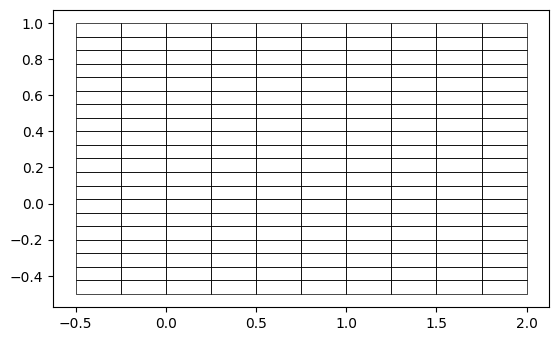

In [2]:
# Task 5
domain = cartesianDomain([-.5, -.5], [2, 1], [10, 20])
gridView = yaspGrid(domain)
gridView.plot()

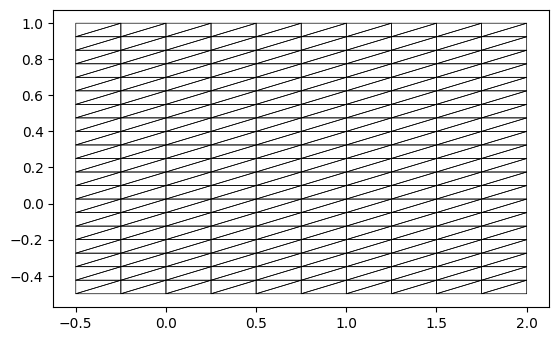

In [3]:
# Task 6
aluView = aluConformGrid(domain)
aluView.plot()

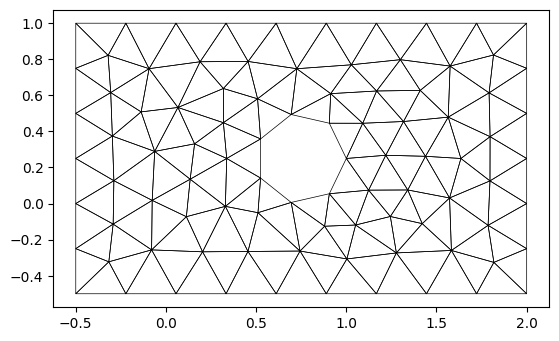

In [4]:
# Task 8
with pygmsh.occ.Geometry() as geom:
    L = 2.5
    H = 1.5
    x_hole = (-0.5+L/2)
    y_hole = (-0.5+H/2)
    radius = 0.25
    rectangle = geom.add_rectangle([-.5, -.5, 0], L, H)
    disk = geom.add_ball([x_hole, y_hole, 0], radius)
    geom.boolean_difference(rectangle, disk)
    mesh = geom.generate_mesh(dim=2)
# Generate domain
points, cells = np.array([np.array([x, y]) for x, y, z in mesh.points]), mesh.cells_dict
#print(type(points), points[0])
#print(cells.keys())
domain = {"vertices":points.astype("float"), "simplices":cells["triangle"]}
# Generate grid
holeGridView = aluConformGrid(domain, dimgrid=2)
holeGridView.plot()

In [5]:
# Task 9
def ourGridWidth(gridView):
    # Iterate through elements in gridView, computing
    # max distance between corners of each
    # The gridWidth of the grid is the largest such distance
    D_max = 0
    # codim of zero -> triangles (top level elements)
    for entity in gridView.entities(codim=0):
        # Get distance between corners, check if any larger than current max
        corners = np.array(entity.geometry.corners)
        for i in range(len(corners)):
            for j in range(i+1, len(corners)):
                D = np.sqrt(np.sum((corners[i]-corners[j])**2))
                if D > D_max:
                    D_max = D
                    #print(f"Found new max: {D_max}")
    return D_max

# Grid width our version
ourWidth = ourGridWidth(holeGridView)
duneWidth = gridWidth(holeGridView)
print(f"Our final grid width: {ourWidth:.5f}")
print(f"Dune grid width: {duneWidth:.5f}")

Our final grid width: 0.31554
Dune grid width: 0.04241


In [ ]:
# Task 10
from dune.fem.function import gridFunction
#from dune.common import FieldVector

# Piece-wise constant grid function that measures the grid width on each element
@gridFunction(holeGridView, name="GridWidth", order=3)
def gridWidthFunction(element, _): # Second parameter for compatibility with the f(e, x) signature expected by dune
    D_max = 0
    corners = np.array(element.geometry.corners)
    for i in range(len(corners)):
        for j in range(i+1, len(corners)):
            D = np.sqrt(np.sum((corners[i]-corners[j])**2))
            if D > D_max:
                D_max = D
    return D_max

# Get max value using the grid function
maxValue = np.max([gridWidthFunction(e, 0) for e in gridWidthFunction.gridView.elements]) # Again, call with second dummy argument to avoid global lookup (hangs program)
print(f"Max width of an element: {maxValue:.5f}")

Max width of an element: 0.31554
